# Sheather and Jones method implementation on Scipy

Reference:

> Sheather, S. J. and Jones, M. C. (1991). A reliable data-based bandwidth selection method for kernel density estimation. Journal of the Royal Statistical Society series B, 53, 683–690. http://www.jstor.org/stable/2345597.

There is an implementation in [KDEpy] package, however does not support 3.11 python version. There is a `longintrepr.h` including error in Cython.

In [1]:
from scipy import stats

In [ ]:
# stats.gaussian_kde(data, be_method, weights)

```.python
bw_methodstr, scalar or callable, optional

    The method used to calculate the estimator bandwidth. This can be ‘scott’, ‘silverman’, a scalar constant or a callable. If a scalar, this will be used directly as kde.factor. If a callable, it should take a gaussian_kde instance as only parameter and return a scalar. If None (default), ‘scott’ is used. See Notes for more details.

```





$n$ step bandwidth 

$$ t = \zeta \gamma^{[n]} (t) $$

**Plug-in method**

1. For a given integer $l >0$, estimate, ${}_*t_{l=1}$ via below equation and $||f^{l+2}||^2$ computed by assuming that $f$ is a normal density with mean and variance estimated from the data. Denote the etimate by ${}_*\hat{t}_{l+1}$
    $${}_*t_j = \left(\frac{1 +(1/2)^{j+0/5}}{3} \frac{1 \cdot 3 \cdot 5 \dots (2j-1)}{N \sqrt{\pi/2}||f^{j+1}||^2} \right)^{2/(3+2j)}$$
2. Use $_*\hat{t}_{l+1}$ to estimate $||f^{(l+1)}||^2$ via the plug-in estimator below (1) and $_*\hat{t}_l$ via (2). then use to estimate and so on until we obtain an estimate of $_*\hat{t}_2$.
    1. $${\widehat{||f^{j}||}}^2 = \frac{(-1)^j}{N} \sum_{k=1}^N \sum_{m=1}^N K^{(2j)} \left( X_k, X_m ; 2t_j\right)$$
    2. $$_*\hat{t}_j = \left(\frac{1 +(1/2)^{j+0/5}}{3} \frac{1 \cdot 3 \cdot 5 \dots (2j-1)}{N \sqrt{\pi/2}\widehat{||f^{j+1}||}^2} \right)^{2/(3+2j)}$$
3. Use the estimate of $_*\hat{t}_2$ to compute $_*\hat{t}$ from 
    $$_*t = \left( \frac{1}{2N \sqrt{\pi} ||f"||^2}\right)^{2/5}$$

---

$$\zeta = \left( \frac{6\sqrt{2}-3}{7}\right)^{2/5} \approx 0.90$$

Alg 1: Improved Sheather-Jones

With given $l>2$ 

1. Initialize with $z_0 = \epsilon$, where $\epsilon$ is machine precision, and $n=0$;
2. Set $z_{n+1} = \zeta \gamma^{[l]}(z_n)$
3. If $|z_{n+1} - z_n|<\epsilon$, stop and set $_*\hat{t} = z_{n+1}$; otherwise, set $n:= n+1$ and repeat from step 2;
4. Deliver the Gaussian kernel density estimator (eq 1) evaluated at $_*\hat{t}$ as the final estimator of $f$, and $_*\hat{t}_2 = \gamma^{[l-1](z_{n+1})}$ as the bandwidth for the optimal estimation of $||f"||^2$

Authors recommend setting: $l=5$. There is no practical differnece by increasing the stages of the bandwidth selection rule beyond $l=5$.

In [27]:
float_eps = 5E-16

In [28]:
import numpy as np
import math

def inline_cache(func):
    cache= {}
    def wrapper(n):
        if n in cache:
            return cache[n]
        else:
            cache[n] = func(n)
            return cache[n]
    return wrapper

@inline_cache
def factorial_odd(n):
    return (2*n-1)*factorial_odd(n-1) if n >1 else 1

In [29]:
const_ra = (2*math.sqrt(2*math.pi))
def estimator_2nd(j, xarr, t):
    N = xarr.size

    X = np.repeat(xarr.reshape(-1, 1), N, axis=1)
    r1 = np.exp(-((X-X.T)**2)/(2*t)).sum()
    coef = (1 if j%2 == 0 else 1)/(N*N)

    return coef*r1/(const_ra*t)

In [30]:
x = np.arange(5)
X = np.repeat(x.reshape(-1, 1), x.size, axis=1)
np.exp(-((X-X.T)**2)/(2*0.4)).sum()

7.332518090188957

In [31]:
spi_const = math.sqrt(math.pi/2)
def gamma(z_n, l, xarr):
    N = xarr.size
    j = 0
    def sub_ep(j, t):
        a_j = (1+math.pow(0.5,j+0.5))/3
        b_j = factorial_odd(j)
        c_j = N* spi_const
        coef_j = a_j*b_j*c_j
        return math.pow(coef_j/estimator_2nd(j, xarr, t), 2/(3+2*j))
    z = z_n
    for j in range(0, l):
        z = sub_ep(l-j+1, z)
    return z

In [55]:
l =4
z_n = 5E-16
n =0
zeta = 0.900000

xarr = np.arange(20)# sample


In [ ]:
z_n_1 = zeta * gamma(z_n, l, xarr)

In [61]:
z_n_1 = zeta * gamma(z_n, l, xarr)
feps = math.fabs(z_n_1-z_n)
print(f"z_n+1:{z_n_1}, eps:{feps}")
print(f"{feps<float_eps}")
z_n = z_n_1

z_n+1:9.60213316985734, eps:0.0
True


In [401]:

const_ra = (2*math.sqrt(2*math.pi))
def estimator_2nd(j, xarr, t):
    N = xarr.size

    X = np.repeat(xarr.reshape(-1, 1), N, axis=1)
    r1 = np.exp(-((X-X.T)/(2*t))**2).sum()
    coef = (1 if j%2 == 0 else 1)/(N*N)

    return coef*r1/(const_ra*t)
spi_const = math.sqrt(math.pi/2)
def gamma(z_n, l, xarr):
    N = xarr.size
    j = 0
    def sub_ep(j, t):
        a_j = (1+math.pow(0.5,j+0.5))/3
        b_j = factorial_odd(j)
        c_j = N* spi_const
        coef_j = a_j*b_j*c_j
        return math.pow(coef_j/estimator_2nd(j, xarr, t), 2/(3+2*j))
    z = z_n
    for j in range(0, l):
        z = sub_ep(l-j+1, z)
        
    star_t = np.power((2*N*np.sqrt(np.pi)*z), -(0.4))
    return star_t
def isj_bandwidth(xarr, 
                  l=5, 
                  z0 = 5E-16, 
                  zeta = 0.90000,
                  max_n = 7,
                  eps = 5E-16):
    z_n = z0
    z_n_1 = 0
    for i in range(2, max_n+1):
        z_n_1 = zeta*gamma(z_n, l, xarr)
        if math.fabs(z_n_1 - z_n) < z0:
            break
    return z_n_1



In [868]:
from numpy.random import default_rng
from matplotlib import pyplot as plt
from scipy.optimize import brentq
from scipy.stats import gaussian_kde
from scipy.stats import norm
def gaussian(x, center, sigma):
    return (1/(sigma*math.sqrt(2 *math.pi)))*np.exp(-((x-center)/sigma)**2)
def gaussian_s(x, centers, sigmas):
    result = 0
    for c,s in zip(centers, sigmas):
        result +=gaussian(x, c, s)
    return result
rng = default_rng()

from kdepy.bw_selection import improved_sheather_jones

def dnorm(x):
    return norm.pdf(x, 0, 1)

def sj(x, h):
    '''
    Equation 12 of Sheather and Jones [1]_
    References
    ----------
    .. [1] A reliable data-based bandwidth selection method for kernel
        density estimation. Simon J. Sheather and Michael C. Jones.
        Journal of the Royal Statistical Society, Series B. 1991
    '''
    phi6 = lambda t: (t ** 6 - 15 *t ** 4 + 45 * t ** 2 - 15) * dnorm(t)
    phi4 = lambda t: (t ** 4 - 6 * t** 2 + 3) * dnorm(t)

    n = len(x)
    one = np.ones((1, n))

    lam = np.percentile(x, 75) - np.percentile(x, 25)
    a = 0.92 * lam * n ** (-1 / 7.0)
    b = 0.912 * lam * n ** (-1 / 9.0)

    W = np.tile(x, (n, 1))
    W = W - W.T

    W1 = phi6(W/b)
    tdb = np.dot(np.dot(one, W1), one.T)
    tdb = -tdb / (n * (n - 1) * b ** 7)

    W1 = phi4(W/a)
    sda = np.dot(np.dot(one, W1), one.T)
    sda = sda / (n * (n - 1) * a ** 5)

    alpha2 = 1.357 * (abs(sda / tdb)) ** (1 / 7.0) * h ** (5 / 7.0)

    W1 = phi4(W/alpha2)
    sdalpha2 = np.dot(np.dot(one, W1), one.T)
    sdalpha2 = sdalpha2 / (n * (n - 1) * alpha2 ** 5)

    return (norm.pdf(0, 0, np.sqrt(2)) /
            (n * abs(sdalpha2[0, 0]))) ** 0.2 - h

In [871]:
sj(samples, 0.2)

0.294574056411902

In [873]:
from scipy.optimize import brentq



/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_8594/2861101677.py:52: RuntimeWarning: divide by zero encountered in divide
  W1 = phi4(W/alpha2)
/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_8594/2861101677.py:52: RuntimeWarning: invalid value encountered in divide
  W1 = phi4(W/alpha2)
/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_8594/2861101677.py:30: RuntimeWarning: invalid value encountered in subtract
  phi4 = lambda t: (t ** 4 - 6 * t** 2 + 3) * dnorm(t)


In [875]:
r

1.1682660168832992

In [856]:
n_s = 15
d = 10


In [885]:
vlas = rng.standard_normal(n_s)
vlas_2 =rng.standard_normal(n_s)+d
#samples = np.concatenate([vlas, vlas_2])
#samples = vlas
samples = np.array([
    21.370, 19.435, 20.363, 20.632, 20.404, 19.893, 21.511, 19.905, 22.018, 19.93,
    31.304, 32.286, 28.611, 29.721, 29.866, 30.635, 29.715, 27.343, 27.559, 31.32,
    39.693, 38.218, 39.828, 41.214, 41.895, 39.569, 39.742, 38.236, 40.460, 39.36,
    50.455, 50.704, 51.035, 49.391, 50.504, 48.282, 49.215, 49.149, 47.585, 50.03
    ])


In [886]:
n_s =  25
s = []
for i in range(10, 60, 10):
    s.append(rng.standard_normal(n_s)+i)
samples = np.concatenate(s)

In [887]:
R = np.max(samples) - np.min(samples)
jsj_bandwidth_h = isj_bandwidth(samples)

In [888]:
b1 = isj_bandwidth(samples)
b2 = improved_sheather_jones(samples.reshape(-1, 1))
b3 = brentq(lambda x: sj(samples, x), a=0, b = 10)

/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_8594/2861101677.py:52: RuntimeWarning: divide by zero encountered in divide
  W1 = phi4(W/alpha2)
/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_8594/2861101677.py:52: RuntimeWarning: invalid value encountered in divide
  W1 = phi4(W/alpha2)
/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_8594/2861101677.py:30: RuntimeWarning: invalid value encountered in subtract
  phi4 = lambda t: (t ** 4 - 6 * t** 2 + 3) * dnorm(t)


In [889]:
print(b1 ,b2 ,b3)

0.025701772703431304 0.3350795986660868 1.134186379069278


In [880]:
bandwidth_shear = improved_sheather_jones(samples.reshape(-1, 1))

In [815]:
bandwidth = np.sqrt(jsj_bandwidth_h)*R/10
bandwidth

0.7121980672644155

In [897]:
kernel = gaussian_kde(samples, b3/10)

In [898]:
x_line = np.linspace(-10, 80, 400)

In [905]:
kernel.set_bandwidth(b3/10)

[None, None]

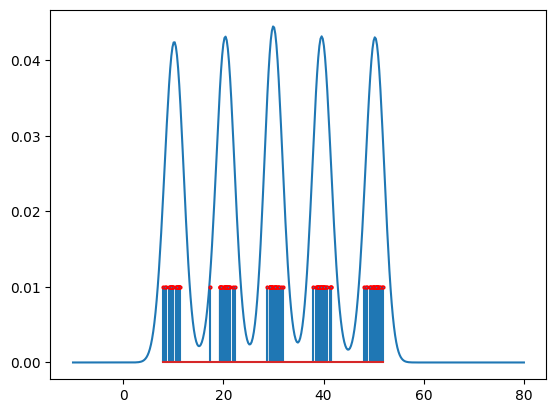

In [906]:
plt.plot(x_line, kernel(x_line))
#plt.plot(x_line, gaussian_s(x_line, [0, d], [1, 1]))

markerline, stemline, baseline =plt.stem(samples, 0.01*np.ones(samples.size))
#plt.plot(x_line, gaussian(x_line, vlas[0], jsj_bandwidth_h))
plt.setp(markerline, markersize = 2, mec="red")
#plt.hlines([1/math.sqrt(2*math.pi)], 0, 5)

In [683]:
def improced_sj(data, weights=None):
    obs, dims = data.shape
    if not dims ==1:
        raise ValueError("")
    n = 2**10

    # Get vaildated weights
    if weights is not None:
        data = data[weights >0]
        weights = weights[weights >0]
    
    x

## Original papers

$R(K) = \int K(x) dx$, $\sigma_K^2 = \int x^2 K(x) dx$

$$h_{op} = root (\left( \frac{R(K)}{\sigma_K^4 \hat{S}_D(\hat{\alpha}_2(h))} \right)^{1/5} - h =0 )$$

$$\hat{S}_D(\alpha) = \frac{1}{n(n-1)} \frac{1}{\alpha^5}\sum \sum \phi^{iv}(\alpha^{-1}(X_i - X_j))$$

$$\hat{\alpha}_2(h) = 1.357 \left( \frac{\hat{S}_D(a)}{\hat{T}_D(b)} \right)^{1/7} h^{5/7}$$

$$\hat{T}_D(b) = -\frac{1}{n(n-1)} b^{-7} \sum \sum \phi^{vi}(b^{-1} (X_i - X_j))$$

$$a = 0.920 \hat{\lambda} n^{-1/7}, b = 0.912 \hat{\lambda} n^{-1/9}$$

$\hat{\lambda}$ is the sample interquartile range

In [ ]:
# Kernel = normal gaussian kernel

def interquartile(data):
    pass

def get_coef(data):
    lambda_h = interquartile(data)
    return 0.920 * lambda_h *np.power(n, -1/7), 0.912 * lambda_h *np.power(n, -1/9)

def S_D(a, n, dX):
    return np.exp(dX/a).sum()/(n*(n-1)*a**5)
def T_D(b, n, dX):
    return -np.exp(dX/b).sum()/(n*(n-1)*b**7)

def alpha_h(h, a, b, n, dX):
    return 1.357 * np.power(S_D(a, n, dX)/T_D(b, n, dX), 1/7) * np.power(h, 5/7)

def R_gaussian():
    return 
def sig_gaussian():
    return 

In [824]:
from typing import Callable, Tuple
from scipy.stats import norm


In [829]:
norm.pdf(0,0, math.sqrt(2))

0.28209479177387814

## Appendix E 

In higher dimensions

Algorithm 1 can be extended to two dimensions for the esitmation of a p.d.f $f(x)$ on $\mathbb{R}^2$. Assuming a Gaussian kernel,

$$\phi(\mathbf{x}, \mathbf{y}; t) = \frac{1}{2 \pi t} \exp \left(-\frac{(\mathbf{x-y})^T (\mathbf{x-y})}{2t} \right)$$

$$t^* = (2 \pi N (\psi_{0, 2} + \psi_{2,0} + 2 \psi_{1,1}))^{-1/3}$$